In [ ]:
!pip3 install yfinance

In [ ]:
!pip3 install ta

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import yfinance as yf

from ta.trend import sma_indicator, ema_indicator

In [2]:
ticker="AMZN"

In [3]:
fillna=False
msft = yf.Ticker(ticker)
df_ticker = msft.history(period="max")

sma_days=9
df_ticker[f'trend_sma_{sma_days}'] = sma_indicator(close=df_ticker['Close'], window=sma_days, fillna=fillna)
sma_days=20
df_ticker[f'trend_sma_{sma_days}'] = sma_indicator(close=df_ticker['Close'], window=sma_days, fillna=fillna)
sma_days=50
df_ticker[f'trend_sma_{sma_days}'] = sma_indicator(close=df_ticker['Close'], window=sma_days, fillna=fillna)
sma_days=200
df_ticker[f'trend_sma_{sma_days}'] = sma_indicator(close=df_ticker['Close'], window=sma_days, fillna=fillna)

ema_days=9
df_ticker[f'trend_ema_{ema_days}'] = ema_indicator(close=df_ticker['Close'], window=ema_days, fillna=fillna)
ema_days=20
df_ticker[f'trend_ema_{ema_days}'] = ema_indicator(close=df_ticker['Close'], window=ema_days, fillna=fillna)
ema_days=50
df_ticker[f'trend_ema_{ema_days}'] = ema_indicator(close=df_ticker['Close'], window=ema_days, fillna=fillna)
ema_days=200
df_ticker[f'trend_ema_{ema_days}'] = ema_indicator(close=df_ticker['Close'], window=ema_days, fillna=fillna)

In [4]:
df1 = df_ticker.copy()
df2 = df_ticker.shift(1)

In [5]:
#df_2 - df_1
df21 = (df1 - df2)
#df.dropna()

In [6]:
temp=[
    df21['trend_sma_9'] > 0,
    df21['trend_ema_9'] > 0,
    df21['trend_sma_20'] > 0,
    df21['trend_ema_20'] > 0,
    df21['trend_sma_50'] > 0,
    df21['trend_ema_50'] > 0,
    df21['trend_sma_200'] > 0,
    df21['trend_ema_200'] > 0,
    ((df1['trend_sma_9'] <= df1['trend_ema_9']) & (df2['trend_sma_9'] >= df2['trend_ema_9'])),
    ((df1['trend_ema_9'] <= df1['trend_sma_9']) & (df2['trend_ema_9'] >= df2['trend_sma_9'])),
    ((df1['trend_sma_20'] <= df1['trend_ema_20']) & (df2['trend_sma_20'] >= df2['trend_ema_20'])),
    ((df1['trend_ema_20'] <= df1['trend_sma_20']) & (df2['trend_ema_20'] >= df2['trend_sma_20'])),
    ((df1['trend_sma_50'] <= df1['trend_ema_50']) & (df2['trend_sma_50'] >= df2['trend_ema_50'])),
    ((df1['trend_ema_50'] <= df1['trend_sma_50']) & (df2['trend_ema_50'] >= df2['trend_sma_50'])),
    ((df1['trend_sma_200'] <= df1['trend_ema_200']) & (df2['trend_sma_200'] >= df2['trend_ema_200'])),
    ((df1['trend_ema_200'] <= df1['trend_sma_200']) & (df2['trend_ema_200'] >= df2['trend_sma_200'])),
    
     ]

all_rules = np.array(temp).T

all_rules.shape

(6490, 16)

In [7]:
# genetic algorithm search of the one max optimization problem
from numpy.random import randint
from numpy.random import rand


# tournament selection
def selection(pop, scores, k=3):
	# first random selection
	selection_ix = randint(len(pop))
	for ix in randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		if scores[ix] > scores[selection_ix]:
			selection_ix = ix
	return pop[selection_ix]

# crossover two parents to create two children
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	# check for recombination
	if rand() < r_cross:
		# select crossover point that is not on the end of the string
		pt = randint(1, len(p1)-2)
		# perform crossover
		c1 = p1[:pt] + p2[pt:]
		c2 = p2[:pt] + p1[pt:]
	return [c1, c2]

# mutation operator
def mutation(bitstring, r_mut):
	for i in range(len(bitstring)):
		# check for a mutation
		if rand() < r_mut:
			# flip the bit
			bitstring[i] = 1 - bitstring[i]

# genetic algorithm
def genetic_algorithm(objective, n_bits, n_iter, n_pop, r_cross, r_mut):
    # initial population of random bitstring
    # pop = randint(2, size=(num_genes, all_rules.shape[1]+4))
    pop = [randint(0, 2, n_bits).tolist() for _ in range(n_pop)]
    # keep track of best solution
    best, best_eval = 0, 0
    all_best_evals=np.zeros(n_iter)
    # enumerate generations
    for gen in range(n_iter):
        # evaluate all candidates in the population
        objs = [objective(c, i, gen) for i, c in enumerate(pop)]
        # check for new best solution
        scores=np.zeros(n_pop)
        for i in range(n_pop):
            
            score, df = objs[i]
            scores[i]=score
            if scores[i] > best_eval:
                best, best_eval = pop[i], scores[i]
                print(">%d, new best f(%s) = %.3f" % (gen,  pop[i], scores[i]))
                new_row=['Sum', '', '', '', '', scores[i]]
                new_df=pd.DataFrame([new_row], columns=cols)
                df=pd.concat([df, new_df], ignore_index=True)
                df.to_csv(f"./{n_iter}generation-outputs/gen{gen}_sol{i}_transactions.csv", index=False)
                np.save(f"./{n_iter}generation-outputs/gen{gen}_sol{i}_rules", best)
            all_best_evals[gen] = best_eval
        # select parents
        selected = [selection(pop, scores) for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
            # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
            # crossover and mutation
            for c in crossover(p1, p2, r_cross):
                # mutation
                mutation(c, r_mut)
                # store for next generation
                children.append(c)
        # replace population
        pop = children
    
    return best, best_eval, all_best_evals

In [8]:
cols=['T', 'Buy date', 'Buy price', 'Sell date',  'Sell price', 'Profit Ratio']
def fitness_func(sol, sol_idx, generation_counter):
    sol=np.array(sol)
    
    df=pd.DataFrame(columns=cols)

    all_profit = []
    current_day, buy_day, sell_day = 200, 0, 0
    conds = np.zeros(sol.shape[0]-1)
    trans_counter=0
    hold_days = 0
    for ele in sol[-4:].astype(dtype=int):
        hold_days = (hold_days << 1) | ele
    
    # print(hold_days, sol[-4:])
    hold_days+=1
        
    counter=0
    while current_day < df1.shape[0]:
        counter+=1
        if current_day+hold_days >= df1.shape[0]:
            break
            
        conds = all_rules[current_day].astype(dtype=int) ^ sol[:-4].astype(dtype=int)
        if sum(conds)==0:
            if buy_day==0: #if the buy signal is seen and buy hasn't been initialized
                trans_counter+=1
                buy_day=current_day
                buy_price=df1.iloc[buy_day+1]['Open']
                buy_date=df1.iloc[buy_day+1].name.strftime("%m/%d/%Y")
                
                current_day=int(hold_days+buy_day)
                sell_day=current_day
                sell_price=df1.iloc[sell_day]['Close']
                sell_date=df1.iloc[sell_day].name.strftime("%m/%d/%Y")
                
                profit=(sell_price-buy_price)/buy_price
                all_profit.append(profit)
                new_row=[f'T{trans_counter}', buy_date, buy_price, sell_date, sell_price, profit]
                new_df=pd.DataFrame([new_row], columns=cols)
                df=pd.concat([df, new_df], ignore_index=True)
                buy_day=0
        else:
            current_day+=1
        conds = np.zeros(sol.shape[0]-1)
    
    if len(all_profit) > 0:
        fitness_val = np.mean(all_profit)
        """if fitness_val > best_gen_fitness_val:
            new_row=[f'Sum', '', '', '', '', fitness_val]
            new_df=pd.DataFrame([new_row], columns=cols)
            df=pd.concat([df, new_df], ignore_index=True)
            df.to_csv(f"./outputs/gen{generation_counter}_sol{sol_idx}_transactions.csv", index=False)
            np.save(f"./outputs/gen{generation_counter}_sol{sol_idx}_rules", sol)
            best_gen_fitness_val=fitness_val"""
        return fitness_val, df
    else:
        return 0.0, df

In [9]:
# define the total iterations
n_iter = 100
# bits
n_bits = all_rules.shape[1]+4
# define the population size
n_pop = 100
# crossover rate
r_cross = 0.9
# mutation rate
r_mut = 1.0 / float(n_bits)
os.mkdir(f"{n_iter}generation-outputs")

In [10]:
# perform the genetic algorithm search
best, score, all_scores = genetic_algorithm(fitness_func, n_bits, n_iter, n_pop, r_cross, r_mut)
print('Done!')
print('f(%s) = %f' % (best, score))

>6, new best f([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1]) = 0.073
>9, new best f([0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]) = 0.141
>10, new best f([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]) = 0.445
Done!
f([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]) = 0.445010


Text(0.5, 1.0, 'AMZN stock')

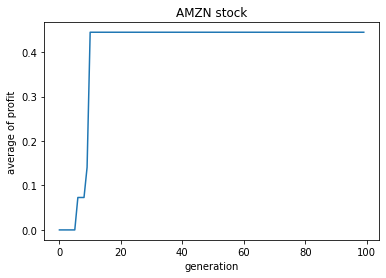

In [11]:
plt.plot(all_scores)
plt.xlabel("generation")
plt.ylabel("average of profit")
plt.title(f"{ticker} stock")

In [12]:
# define the total iterations
n_iter = 1000
# bits
n_bits = all_rules.shape[1]+4
# define the population size
n_pop = 100
# crossover rate
r_cross = 0.9
# mutation rate
r_mut = 1.0 / float(n_bits)
os.mkdir(f"{n_iter}generation-outputs")

In [13]:
# perform the genetic algorithm search
best, score, all_scores = genetic_algorithm(fitness_func, n_bits, n_iter, n_pop, r_cross, r_mut)
print('Done!')
print('f(%s) = %f' % (best, score))

>0, new best f([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) = 0.007
>0, new best f([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]) = 0.028
>12, new best f([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1]) = 0.033
>15, new best f([1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]) = 0.203
>17, new best f([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1]) = 0.207
>25, new best f([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0]) = 0.322
>87, new best f([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]) = 0.594
>432, new best f([0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]) = 0.711
Done!
f([0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]) = 0.710966


Text(0.5, 1.0, 'AMZN stock')

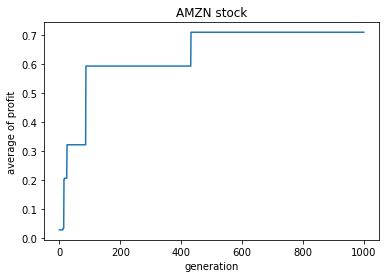

In [14]:
plt.plot(all_scores)
plt.xlabel("generation")
plt.ylabel("average of profit")
plt.title(f"{ticker} stock")